<a href="https://colab.research.google.com/github/Anasse-lm/Ambiguity_model/blob/main/ambiguity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Multi-Label User Story Ambiguity Classification (Thesis Edition)
This notebook fine-tunes DistilBERT and provides extensive evaluation, logging, and visualization for research and thesis defense.

In [10]:
!pip install pandas openpyxl scikit-learn transformers torch matplotlib seaborn tqdm

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set(style="whitegrid")

## Configuration

In [12]:
MODEL_NAME = "microsoft/deberta-v3-base"
FILE_PATH = "/content/sample_data/Cornelius_2025_user_story_ambiguity_dataset.xlsx"
TEXT_COLUMN = "StoryText"
LABEL_COLUMNS = [
    "SemanticAmbiguity","ScopeAmbiguity","ActorAmbiguity",
    "AcceptanceAmbiguity", #"DependencyAmbiguity",
    "PriorityAmbiguity","TechnicalAmbiguity"
]

MAX_LEN = 160
BATCH_SIZE = 12
EPOCHS = 5
LR = 2e-5
PATIENCE = 8

## Dataset Class

In [13]:
class AmbiguityDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df[TEXT_COLUMN].astype(str).tolist()
        self.labels = df[LABEL_COLUMNS].values
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        return {
            "ids": enc["input_ids"].flatten(),
            "mask": enc["attention_mask"].flatten(),
            "targets": torch.tensor(self.labels[idx], dtype=torch.float)
        }

## Load Data & Compute Class Weights

In [14]:
df = pd.read_excel(FILE_PATH, engine="openpyxl")
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print("Train:", train_df.shape, "Validation:", val_df.shape)

Train: (10277, 24) Validation: (2570, 24)


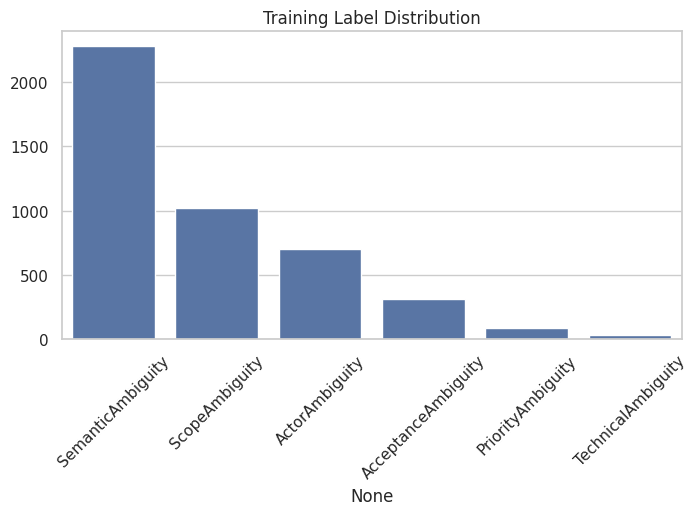

In [15]:
label_counts = train_df[LABEL_COLUMNS].sum()

plt.figure(figsize=(8,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Training Label Distribution")
plt.xticks(rotation=45)
plt.show()

## Model, Optimizer, Scheduler

In [16]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABEL_COLUMNS),
    problem_type="multi_label_classification"
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

pos_weights = (len(train_df) - label_counts) / label_counts
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weights.values, dtype=torch.float).to(device))

train_loader = DataLoader(AmbiguityDataset(train_df, tokenizer), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(AmbiguityDataset(val_df, tokenizer), batch_size=BATCH_SIZE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training & Evaluation Functions

In [17]:
history = []
best_val = float("inf")
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        ids = batch["ids"].to(device)
        mask = batch["mask"].to(device)
        targets = batch["targets"].to(device)

        optimizer.zero_grad()
        outputs = model(ids, attention_mask=mask)
        loss = loss_fn(outputs.logits, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0
    probs, y_true = [], []

    with torch.no_grad():
        for batch in val_loader:
            ids = batch["ids"].to(device)
            mask = batch["mask"].to(device)
            targets = batch["targets"].to(device)

            outputs = model(ids, attention_mask=mask)
            loss = loss_fn(outputs.logits, targets)
            val_loss += loss.item()

            probs.append(torch.sigmoid(outputs.logits).cpu())
            y_true.append(targets.cpu())

    probs = np.vstack(probs)
    y_true = np.vstack(y_true)
    preds = (probs > 0.5).astype(int)

    f1_micro = f1_score(y_true, preds, average="micro")
    f1_macro = f1_score(y_true, preds, average="macro")

    history.append({
        "epoch": epoch+1,
        "train_loss": train_loss/len(train_loader),
        "val_loss": val_loss/len(val_loader),
        "f1_micro": f1_micro,
        "f1_macro": f1_macro
    })

    print(f"Train Loss: {history[-1]['train_loss']:.4f} | Val Loss: {history[-1]['val_loss']:.4f}")
    print(f"F1 Micro: {f1_micro:.4f} | F1 Macro: {f1_macro:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_deberta_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered")
            break


Epoch 1: 100%|██████████| 857/857 [06:35<00:00,  2.16it/s]


Train Loss: 0.6905 | Val Loss: 0.4536
F1 Micro: 0.7221 | F1 Macro: 0.6828


Epoch 2: 100%|██████████| 857/857 [06:35<00:00,  2.17it/s]


Train Loss: 0.3760 | Val Loss: 0.4342
F1 Micro: 0.7389 | F1 Macro: 0.7841


Epoch 3: 100%|██████████| 857/857 [06:35<00:00,  2.17it/s]


Train Loss: 0.3622 | Val Loss: 0.4369
F1 Micro: 0.7380 | F1 Macro: 0.7956


Epoch 4: 100%|██████████| 857/857 [06:35<00:00,  2.17it/s]


Train Loss: 0.3460 | Val Loss: 0.4145
F1 Micro: 0.7427 | F1 Macro: 0.8225


Epoch 5: 100%|██████████| 857/857 [06:35<00:00,  2.17it/s]


Train Loss: 0.3311 | Val Loss: 0.3999
F1 Micro: 0.7406 | F1 Macro: 0.8195


## Training Curves

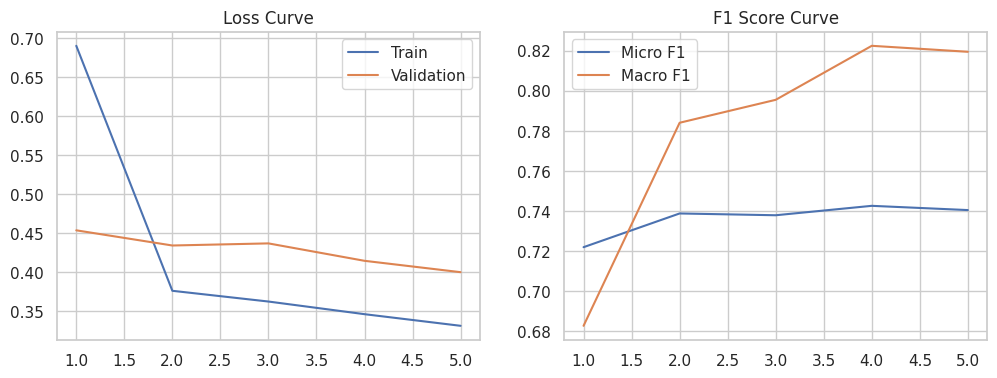

In [18]:
hist = pd.DataFrame(history)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.epoch, hist.train_loss, label="Train")
plt.plot(hist.epoch, hist.val_loss, label="Validation")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch, hist.f1_micro, label="Micro F1")
plt.plot(hist.epoch, hist.f1_macro, label="Macro F1")
plt.title("F1 Score Curve")
plt.legend()

plt.show()

## Per-Class Metrics

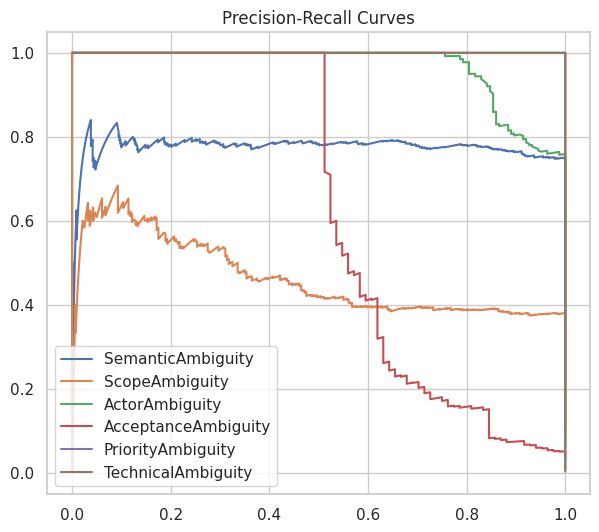

In [19]:
plt.figure(figsize=(7,6))
for i, label in enumerate(LABEL_COLUMNS):
    p, r, _ = precision_recall_curve(y_true[:, i], probs[:, i])
    plt.plot(r, p, label=label)

plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

## ROC & Precision-Recall Curves

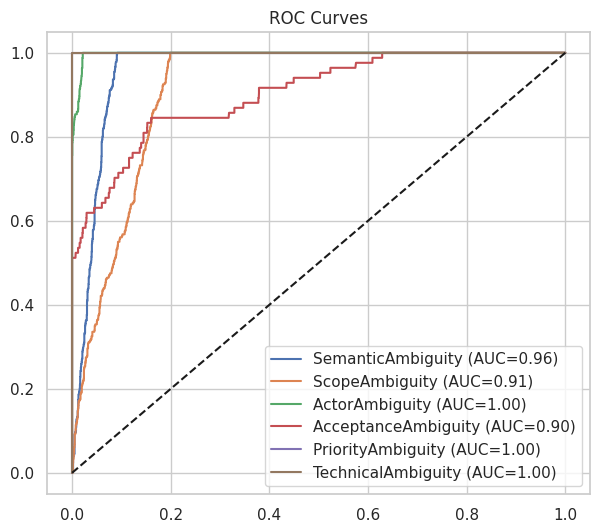

In [20]:
plt.figure(figsize=(7,6))
for i, label in enumerate(LABEL_COLUMNS):
    fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves")
plt.legend()
plt.show()


## Confusion Matrix per Label

In [21]:
print(classification_report(y_true, (probs > 0.5).astype(int), target_names=LABEL_COLUMNS))

                     precision    recall  f1-score   support

  SemanticAmbiguity       0.75      1.00      0.86       552
     ScopeAmbiguity       0.38      0.99      0.55       280
     ActorAmbiguity       0.76      0.97      0.85       164
AcceptanceAmbiguity       0.93      0.51      0.66        84
  PriorityAmbiguity       1.00      1.00      1.00        22
 TechnicalAmbiguity       1.00      1.00      1.00         7

          micro avg       0.60      0.95      0.74      1109
          macro avg       0.80      0.91      0.82      1109
       weighted avg       0.68      0.95      0.77      1109
        samples avg       0.20      0.32      0.24      1109



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Threshold Tuning Example

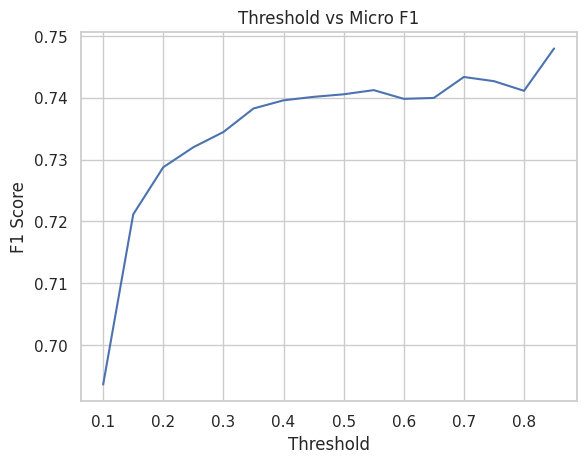

In [23]:
ths = np.arange(0.1, 0.9, 0.05)
scores = [f1_score(y_true, (probs > t).astype(int), average="micro") for t in ths]

plt.plot(ths, scores)
plt.title("Threshold vs Micro F1")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.show()